## Tutorial 

In [ ]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cf_xarray as cfxr

def normalize(data):
    # Normalize the explained variance
    def _normalization(index):
        band = data.isel(component=index).values
        band_min = np.quantile(band, 0.02)
        band_max = np.quantile(band, 0.98)
        return np.clip((band - band_min) / (band_max - band_min), 0, 1)
        # return (band - np.nanmin(band)) / (np.nanmax(band) - np.nanmin(band))
    normalized_red = _normalization(1)  # Red is the second component
    normalized_green = _normalization(0)  # Green is the first component
    normalized_blue = _normalization(2)  # blue is the third component
    # Stack the components into a 3D array
    return np.stack((normalized_red, normalized_green, normalized_blue), axis=-1)


In [25]:
# Load eco_cluster
folder_path = "/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-02-10_15:45:29_deep_extreme_HR/EVI_EN/customcube_CO-MEL_1.95_-72.60_S2_v0.zarr/customcube_CO-MEL_1.95_-72.60_S2_v0.zarr/customcube_CO-MEL_1.95_-72.60_S2_v0.zarr/"
data = xr.open_zarr(folder_path + "eco_clusters.zarr")
data = cfxr.decode_compress_to_multi_index(data, "location")
data = data.eco_clusters.transpose("location", "component", ...)
data

<xarray.DataArray 'eco_clusters' (location: 1243225, component: 3)> Size: 30MB
dask.array<open_dataset-eco_clusters, shape=(1243225, 3), dtype=int64, chunksize=(1243225, 3), chunktype=numpy.ndarray>
Coordinates:
  * component  (component) int64 24B 0 1 2
  * location   (location) object 10MB MultiIndex
  * longitude  (location) float64 10MB -72.65 -72.65 -72.65 ... -72.55 -72.55
  * latitude   (location) float64 10MB 2.0 2.0 2.0 2.0 2.0 ... 1.9 1.9 1.9 1.9

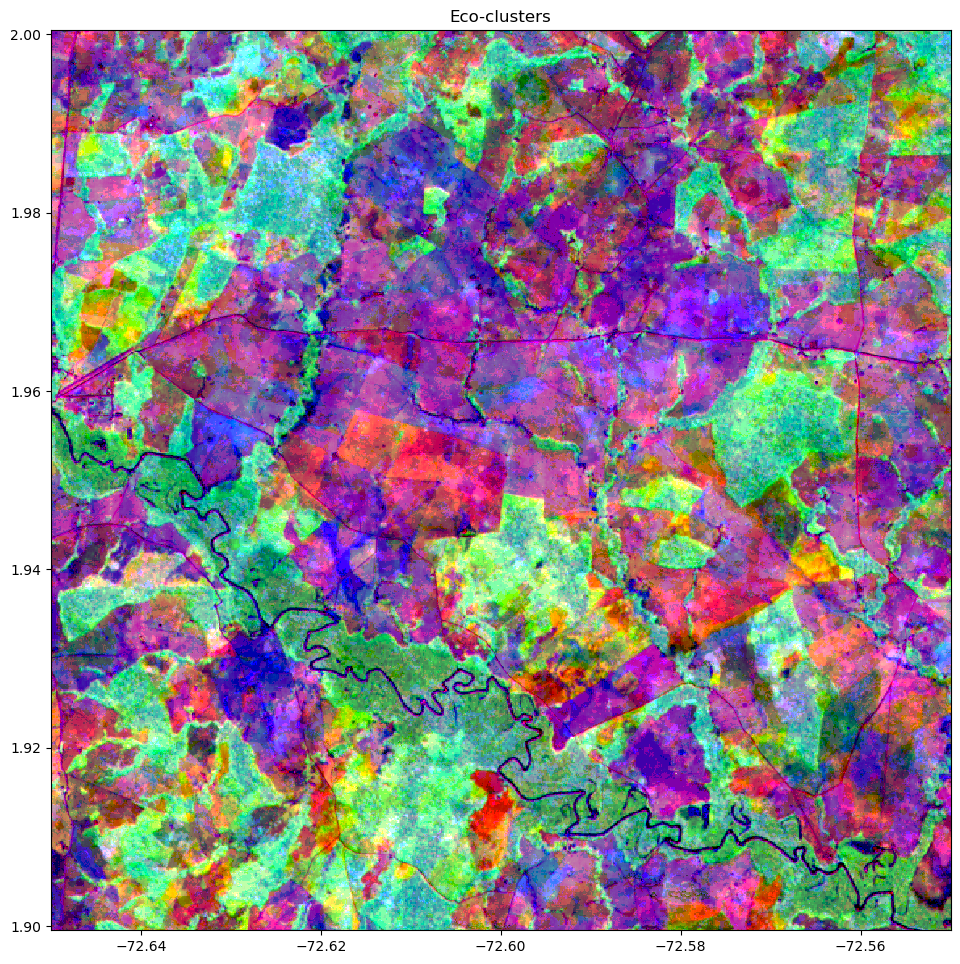

In [ ]:
# Visualize eco_clusters
bins = data.unstack("location")
# Normalize the explained variance
rgb_normalized = normalize(bins)
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
# adjust the plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
ax.pcolormesh(
    bins.longitude.values,
    bins.latitude.values,
    rgb_normalized.transpose(1, 0, 2),
    # transform=projection,
)
# Add a title
plt.title("Eco-clusters")
plt.show()

In [ ]:
# Find the eco_cluster of a location:
eco_cluster = data.unstack("location")

eco_cluster = eco_cluster.sel(longitude=-72.60, latitude=1.92,  method="nearest")
# or eco_cluster = data.isel(location=(-72.64996840058468, 2.0004233024312703))

# Get the values of the eco_cluster
eco_cluster_value = (eco_cluster.sel(component=0).values.item(), eco_cluster.sel(component=1).values.item(), eco_cluster.sel(component=2).values.item())
eco_cluster_value

(32, 1, 2)

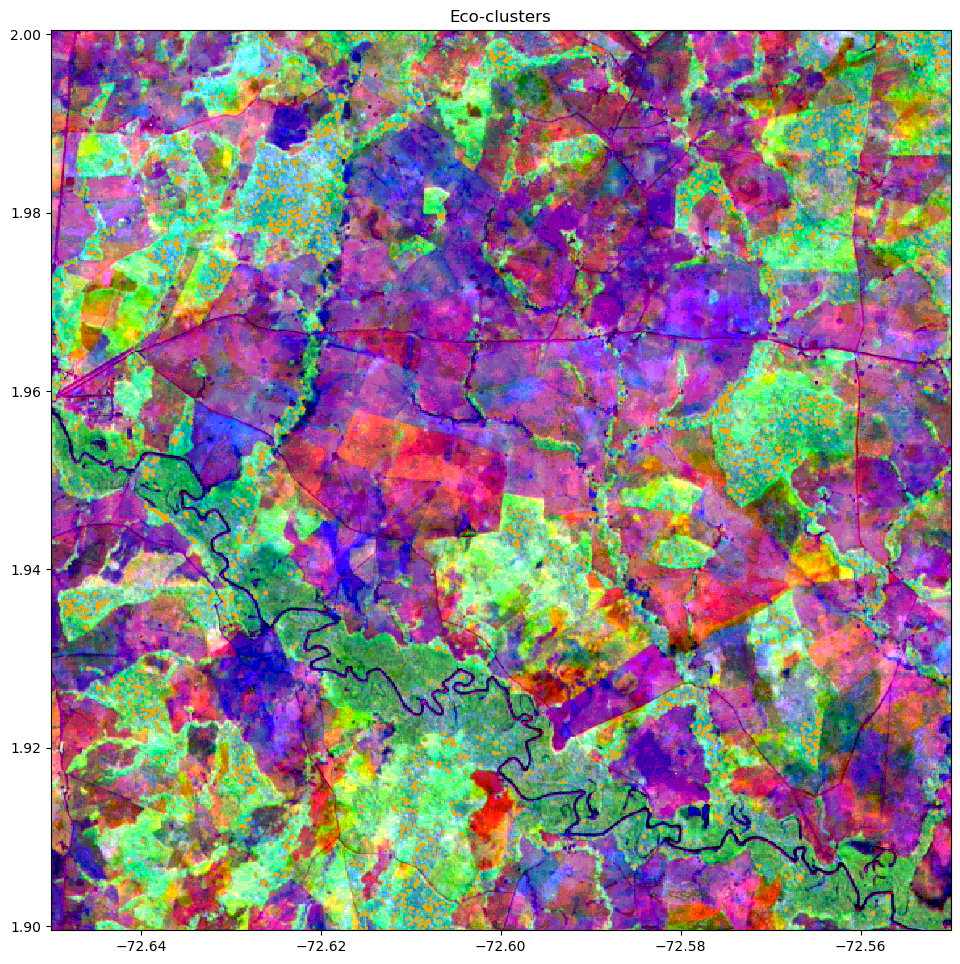

In [ ]:
# Plot all the location in the same eco_cluster
# Compare the entire dataset to find matching locations
matching_mask = (data.sel(component=0).values == eco_cluster_value[0]) & \
                (data.sel(component=1).values == eco_cluster_value[1]) & \
                (data.sel(component=2).values == eco_cluster_value[2])

# Extract the locations where all components match
single_cluster = data[matching_mask]

# Visualize the single cluster
bins = data.unstack("location")
rgb_normalized = normalize(bins)
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
# adjust the plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
ax.pcolormesh(
    bins.longitude.values,
    bins.latitude.values,
    rgb_normalized.transpose(1, 0, 2),
    # transform=projection,
)
ax.scatter(single_cluster.longitude.values, single_cluster.latitude.values, color='orange', s=1) 

plt.title("Eco-clusters")
plt.show()

(1243225,)
<xarray.Dataset> Size: 393MB
Dimensions:      (dayofyear: 73, location: 1243225)
Coordinates:
  * dayofyear    (dayofyear) float64 584B 3.5 8.5 13.5 ... 353.5 358.5 363.5
    source_path  <U100 400B '/Net/Groups/BGI/work_5/scratch/FluxSitesMiniCube...
  * location     (location) object 10MB MultiIndex
  * longitude    (location) float64 10MB -72.65 -72.65 -72.65 ... -72.55 -72.55
  * latitude     (location) float64 10MB 2.0 2.0 2.0 2.0 2.0 ... 1.9 1.9 1.9 1.9
Data variables:
    msc          (location, dayofyear) float32 363MB dask.array<chunksize=(459649, 73), meta=np.ndarray>
<xarray.Dataset> Size: 2MB
Dimensions:      (dayofyear: 73, location: 5876)
Coordinates:
  * dayofyear    (dayofyear) float64 584B 3.5 8.5 13.5 ... 353.5 358.5 363.5
    source_path  <U100 400B '/Net/Groups/BGI/work_5/scratch/FluxSitesMiniCube...
  * location     (location) object 47kB MultiIndex
  * longitude    (location) float64 47kB -72.65 -72.65 -72.65 ... -72.55 -72.55
  * latitude     (location

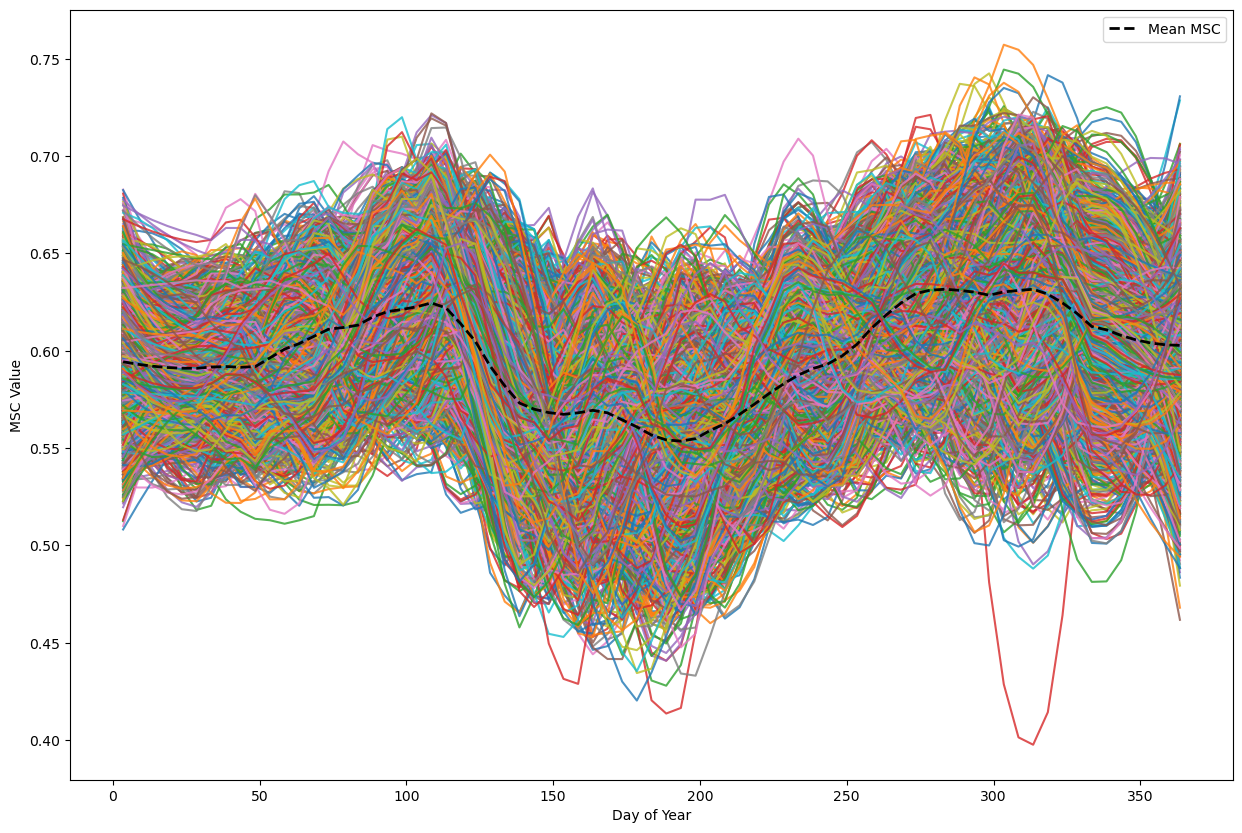

In [39]:
# Visualize the MSC 
    # Load and preprocess the time series dataset
data = xr.open_zarr(folder_path + "msc.zarr")
data = cfxr.decode_compress_to_multi_index(data, "location")
subset = data.isel(location=matching_mask)

# Plot the time series with corresponding colors
fig, ax = plt.subplots(figsize=(15, 10))
for i, loc in enumerate(subset.location):
    ax.plot(
        subset.dayofyear,
        subset.msc.isel(location=i),
        alpha=0.8,
    )
# Calculate and plot the mean MSC across all locations
mean_msc = subset.msc.mean(dim="location")
ax.plot(
    subset.dayofyear,
    mean_msc,
    color="black",
    linestyle="--",
    linewidth=2,
    label="Mean MSC",
)

plt.xlabel("Day of Year")
plt.ylabel("MSC Value")
plt.legend()
plt.show()